# Modelling and fitting a single line spectrum

In [1]:
import orb.fit
import pylab as pl
import numpy as np

### Retrieve the observation parameters of a cube of data

Basic observation parameters can be retrieved from any data cube. 
They are useful to simulate a spectrum which corresponds to your data.

In [2]:
# import base class for the manipulation of a SITELLE spectral cube: HDFCube
from orcs.process import SpectralCube

In [3]:
# load spectral cube
cube = SpectralCube('/home/thomas/M31_SN3.merged.cm1.1.0.hdf5')
print('step (scan step size in nm): ', cube.params.step)
print('order: ', cube.params.order)
print('number of steps: ', cube.params.step_nb)
print('zpd_index', cube.params.zpd_index)
print('axis correction coefficient (calibration coefficient of the wavenumber axis which only depends on theta)', cube.params.axis_corr)

dev.dfbca|INFO| Cube is level 3
dev.dfbca|INFO| shape: (2048, 2064, 840)
dev.dfbca|INFO| wavenumber calibration: True
dev.dfbca|INFO| flux calibration: True
dev.dfbca|INFO| wcs calibration: True


step (scan step size in nm):  2943.025792
order:  8.0
number of steps:  840
zpd_index 168
axis correction coefficient (calibration coefficient of the wavenumber axis which only depends on theta) 1.0374712062298759


### Model a spectrum with one Halpha line

incident angle theta (in degrees): 15.445939567249903


(15200, 15270)

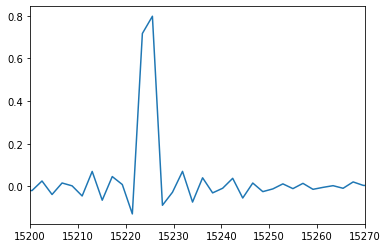

In [4]:
from orb.core import Lines
halpha_cm1 = Lines().get_line_cm1('Halpha')

step = 2943
order = 8
step_nb = 840
axis_corr = 1.0374712062298759
theta = orb.utils.spectrum.corr2theta(axis_corr)
print('incident angle theta (in degrees):', theta)
zpd_index = 168

# model spectrum
velocity = 250
broadening = 10.
spectrum_axis, spectrum = orb.fit.create_cm1_lines_model_raw([halpha_cm1], [1], step, order, step_nb, axis_corr, zpd_index=zpd_index, fmodel='sincgauss',
                                                                  sigma=broadening, vel=velocity)

# add noise (can be commented to obtain a noise free spectrum)
spectrum += np.random.standard_normal(spectrum.shape) * 0.01

pl.plot(spectrum_axis, spectrum)
pl.xlim((15200, 15270))


### Fit the spectrum with a classic Levenberg-Marquardt algorithm

velocity (in km/s):  [250.39(27)]
broadening (in km/s):  [11.24(76)]
flux (in the unit of the spectrum amplitude / unit of the axis fwhm):  [1.200(16)]


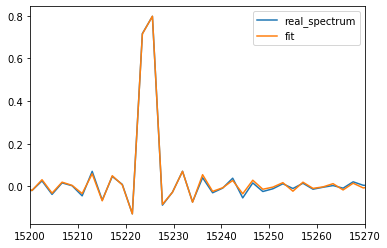

In [5]:
nm_laser = 543.5 # wavelength of the calibration laser, in fact it can be any real positive number (e.g. 1 is ok)
# note: an apodization of 1 means: no apodization (which is the case here)
#
# pos_cov is the velocity of the lines in km/s. It is a covarying parameter,
# because the reference position -i.e. the initial guess- of the lines is set
# 
# sigma_guess is the initial guess on the broadening (in km/s)
fit = orb.fit.fit_lines_in_spectrum(spectrum, [halpha_cm1], step, order, nm_laser, theta, zpd_index=zpd_index, 
                                    wavenumber=True, apodization=1, fmodel='sincgauss',
                                    pos_def=['1'], 
                                    pos_cov=velocity, sigma_guess=broadening)

# velocity and broadening should be exact at the machine precision if no noise is present in the spectrum.
print('velocity (in km/s): ', fit['velocity_gvar'])
print('broadening (in km/s): ', fit['broadening_gvar'])
print('flux (in the unit of the spectrum amplitude / unit of the axis fwhm): ', fit['flux_gvar'])
pl.plot(spectrum_axis, spectrum, label='real_spectrum')
pl.plot(spectrum_axis, fit['fitted_vector'], label='fit')
pl.xlim((15200, 15270))
pl.legend()